In [2]:
import os
import git
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook as tqdm
import ast
import re
import pickle
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score

In [3]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Reshape
from keras.layers import Average
# from keras_contrib.layers import CRF
from sklearn.model_selection import train_test_split
import keras
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [4]:
pd.set_option('display.max_colwidth', -1)

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [6]:
# get the git repo
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [7]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [8]:
# setup env
# setup env
import nltk
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/akshayuppal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akshayuppal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
## tokenize the text..
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
def get_tokens(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tokens = tknzr.tokenize(sentence)
    tokens = [token for token in tokens if (token not in stopwords and len(token) > 1)]
    tokens = [get_lemma(token) for token in tokens]
    return (tokens)

In [10]:
def clean_text(text):
    text = re.sub(r'(https?://\S+)', "", text)
    text = re.sub(r'(\@\w+)', "author",text)
    text.rstrip
    text.lstrip
    return(text)

In [11]:
def get_git_root(path):
    git_repo = git.Repo(path, search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root

In [12]:
embeddings_dir  = os.path.join(get_git_root(os.getcwd()),"input","embeddings")
extract_dir = os.path.join(get_git_root(os.getcwd()),"input","hexagon_extract")
annotatted_dir = "/home/samarthgoal/misc_data/annotated_data/"
classifier_dir = os.path.join(get_git_root(os.getcwd()),"models","classifier")
input_dir = os.path.join(get_git_root(os.getcwd()),"input")
model_dir = os.path.join(get_git_root(os.getcwd()),"models")

In [13]:
df_hexagon_data = pd.read_csv(os.path.join(input_dir,"hexagonData.csv"),lineterminator="\n")

In [16]:
poly_users_path = os.path.join(get_git_root(os.getcwd()),"models","poly_users")
input_dir = os.path.join(get_git_root(os.getcwd()),"input")

In [23]:
poly_users = pickle.load(open(os.path.join(poly_users_path,"poly_users.pkl"),"rb"))
total_users = pickle.load(open(os.path.join(poly_users_path,"total_users.pkl"),"rb"))
df_following_final = pd.read_csv(os.path.join(input_dir,"following_final.csv"))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/akshayuppal/Desktop/thesis/twitter_juul/models/poly_users/total_users.pkl'

In [24]:
glove_file = os.listdir(embeddings_dir)[0]
annotatted_files = os.listdir(annotatted_dir)
hexagon_files = [file for file in os.listdir(extract_dir) if file.endswith(".csv")]

FileNotFoundError: [Errno 2] No such file or directory: '/home/samarthgoal/misc_data/annotated_data/'

### preparing the  data

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
def get_tokens(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tokens = tknzr.tokenize(sentence)
    tokens = [token for token in tokens if (token not in stopwords and len(token) > 1 and token.isalpha())]
    tokens = [get_lemma(token) for token in tokens]
    return (tokens)

In [18]:
# create the word2vec dict from the dictionary
def get_word2vec(file_path):
    file = open(file_path, "r")
    if (file):
        word2vec = dict()
        split = file.read().splitlines()
        for line in split:
            key = line.split(' ',1)[0] # the first word is the key
            value = np.array([float(val) for val in line.split(' ')[1:]])
            word2vec[key] = value
        return (word2vec)
    else:
        print("invalid fiel path")

In [19]:
class MeanEmbeddingVectorizer(object):
	def __init__(self, word2vec):
		self.word2vec = word2vec
		# if a text is empty we should return a vector of zeros
		# with the same dimensionality as all the other vectors
		self.dim = len(next(iter(word2vec.values())))

	def fit(self, X, y):
		return self

	def transform(self, X):
		return np.array([
			np.mean([self.word2vec[w] for w in words if w in self.word2vec]
					or [np.zeros(self.dim)], axis=0)
			for words in tqdm(X)
		])

In [73]:
## extracting the annotated data
df_annotation = pd.DataFrame()
for file in annotatted_files:
    df_ = pd.read_excel(os.path.join(annotatted_dir,file),index_col=0)
    columns = (df_.columns)
    df_ = df_.rename(columns={columns[1]: "label", columns[0]: "tweetText"})
    frames = [df_,df_annotation]
    df_annotation = pd.concat(frames,ignore_index=True)

Index(['tweetText', 'label (1: news or research or study, \n2: promotion, \n3: user tweet)'], dtype='object')
Index(['tweetText', 'label (1: news or research or study, \n2: promotion, \n3: user tweet)'], dtype='object')
Index(['tweetText', 'label (1: news or research or study, 2: promotion, 3: user tweet, )'], dtype='object')
Index(['tweetText', 'label (1: news or research or study, 2: promotion, 3: user tweet, )'], dtype='object')


In [74]:
columns = (df_annotation.columns)

In [75]:
columns

Index(['tweetText', 'label'], dtype='object')

In [76]:
len(df_annotation)

519

In [77]:
df_annotation = df_annotation.sample(frac=1).reset_index(drop=True)

In [78]:
len(df_annotation)

519

In [79]:
## tokenize the sentences..
df_annotation['tweetText'] = df_annotation['tweetText'].apply(clean_text)

In [80]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [82]:
token_list = list(df_annotation['tweetText'].apply(get_tokens))
y = (list(df_annotation['label']))
y = le.fit_transform(y)

In [83]:
max_len = len(max(token_list, key=len))

In [84]:
max_len

55

In [85]:
# prepare the input: pad and fit
# prepare tokenizer
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(token_list)
vocab_size = len(t.word_index) + 1
vocab_size

2843

In [88]:
word2vec = get_word2vec(os.path.join(embeddings_dir,embedding_file))

NameError: name 'embedding_file' is not defined

In [811]:
vocab_size = vocab_size
encoded_docs = t.texts_to_sequences(token_list)
max_len = max_len

In [806]:
X = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
y = y

In [809]:
## train test split
X_train,X_test,Y_train,Y_test  = train_test_split(X, y,test_size =0.20,random_state= 4 )

In [810]:
## get the embedding matrix weights:
from numpy import zeros
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [458]:
## pass to the bi-lstm model
max_len= 60
input = Input(shape=(max_len,))
model = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=max_len)(input)
model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
model = TimeDistributed(Dense(100,activation='relu'))(model)
model = Flatten()(model)
model = Dense(100,activation='relu')(model)
output = Dense(3,activation='softmax')(model)

In [459]:
model = Model(input,output)

In [460]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [461]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_34 (Embedding)     (None, 60, 100)           284300    
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 60, 200)           160800    
_________________________________________________________________
time_distributed_28 (TimeDis (None, 60, 100)           20100     
_________________________________________________________________
flatten_24 (Flatten)         (None, 6000)              0         
_________________________________________________________________
dense_76 (Dense)             (None, 100)               600100    
_________________________________________________________________
dense_77 (Dense)             (None, 3)                 303       
Total para

In [462]:
## pass the training data
model.fit(X_train,Y_train,validation_split=0.25, nb_epoch = 10, verbose = 2)

/home/samarthgoal/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 311 samples, validate on 104 samples
Epoch 1/10
 - 14s - loss: 1.0601 - acc: 0.4405 - val_loss: 1.0292 - val_acc: 0.5577
Epoch 2/10
 - 3s - loss: 0.9096 - acc: 0.6045 - val_loss: 0.9163 - val_acc: 0.5865
Epoch 3/10
 - 4s - loss: 0.7607 - acc: 0.6656 - val_loss: 0.9105 - val_acc: 0.6250
Epoch 4/10
 - 3s - loss: 0.6692 - acc: 0.7235 - val_loss: 0.9828 - val_acc: 0.6250
Epoch 5/10
 - 3s - loss: 0.5839 - acc: 0.7685 - val_loss: 0.8812 - val_acc: 0.6538
Epoch 6/10
 - 3s - loss: 0.4938 - acc: 0.8264 - val_loss: 0.9705 - val_acc: 0.5962
Epoch 7/10
 - 3s - loss: 0.4833 - acc: 0.8071 - val_loss: 1.0160 - val_acc: 0.6635
Epoch 8/10
 - 3s - loss: 0.3975 - acc: 0.8392 - val_loss: 1.0637 - val_acc: 0.5962
Epoch 9/10
 - 3s - loss: 0.3161 - acc: 0.8907 - val_loss: 1.0680 - val_acc: 0.6731
Epoch 10/10
 - 3s - loss: 0.2768 - acc: 0.8939 - val_loss: 1.1217 - val_acc: 0.6346


In [470]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 75.000000


In [464]:
from sklearn.metrics import classification_report,confusion_matrix
Y_pred = model.predict(X_test)
y_pred = np.array([np.argmax(pred) for pred in Y_pred])
print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85        39
           1       0.70      0.57      0.63        28
           2       0.70      0.76      0.73        37

   micro avg       0.75      0.75      0.75       104
   macro avg       0.74      0.73      0.73       104
weighted avg       0.75      0.75      0.75       104
 



In [323]:
# evaluate the model
##with max_len =55
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 77.884615


In [324]:
##with max_len =55
from sklearn.metrics import classification_report,confusion_matrix
Y_pred = model.predict(X_test)
y_pred = np.array([np.argmax(pred) for pred in Y_pred])
print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89        39
           1       0.66      0.68      0.67        28
           2       0.81      0.68      0.74        37

   micro avg       0.78      0.78      0.78       104
   macro avg       0.77      0.77      0.76       104
weighted avg       0.78      0.78      0.78       104
 



In [476]:
## dump the classifier(neural model)
import pickle
filename = os.path.join(classifier_dir,"lstm_model.pkl")
with open(filename,"wb") as f:
    pickle.dump(model,f)

### getting the baseline with simple models

In [493]:
vect = MeanEmbeddingVectorizer(word2vec)
X = vect.transform(token_list)
y = y

100%|██████████| 519/519 [00:00<00:00, 21238.54it/s]


In [494]:
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)

In [495]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [496]:
etree = ExtraTreesClassifier(n_estimators=200)
etree.fit(X_train,Y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [497]:
def svm_wrapper(X_train,Y_train):
    param_grid = [
    {'C': [1, 10], 'kernel': ['linear']},
    {'C': [1, 10], 'gamma': [0.1,0.01], 'kernel': ['rbf']},]
    svm1 = GridSearchCV(SVC(),param_grid)
    svm1.fit(X_train, Y_train)
    return(svm1)

In [498]:
sv = svm_wrapper(X_train,Y_train)

/home/samarthgoal/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [499]:
Y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
accuracy_score(Y_test, Y_pred)

  Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.78      0.67        49
           1       0.27      0.08      0.13        36
           2       0.56      0.69      0.62        45

   micro avg       0.55      0.55      0.55       130
   macro avg       0.48      0.52      0.47       130
weighted avg       0.49      0.55      0.50       130
 



0.5538461538461539

In [500]:
Y_pred = sv.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
accuracy_score(Y_test, Y_pred)

  Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.76      0.73        49
           1       0.56      0.39      0.46        36
           2       0.60      0.69      0.64        45

   micro avg       0.63      0.63      0.63       130
   macro avg       0.62      0.61      0.61       130
weighted avg       0.62      0.63      0.62       130
 



0.6307692307692307

In [502]:
Y_pred = etree.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
accuracy_score(Y_test, Y_pred)

  Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.73      0.72        49
           1       0.46      0.31      0.37        36
           2       0.60      0.73      0.66        45

   micro avg       0.62      0.62      0.62       130
   macro avg       0.59      0.59      0.58       130
weighted avg       0.60      0.62      0.60       130
 



0.6153846153846154

In [503]:
score = cross_val_score(etree,X,y)
score

/home/samarthgoal/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.53448276, 0.53179191, 0.61046512])

## lets predict with the model
## merging and loading the input file

In [27]:
hexagon_files

['hexagon_extract_2017.csv',
 'hexagon_extract_2018_6129.csv',
 'hexagon_extract_2017_21499.csv',
 'hexagon_extract_2018.csv',
 'hexagon_extract_2016_24825.csv',
 'hexagon_extract_2018_10860.csv',
 'hexagon_extract_2015.csv',
 'hexagon_extract_2018_15843.csv',
 'hexagon_extract_2018_28531.csv',
 'hexagon_extract_2014.csv',
 'hexagon_extract_2018_21857.csv',
 'hexagon_extract_2016.csv',
 'hexagon_extract_2015_31744.csv']

In [28]:
## merge all of the files
df_final = pd.DataFrame()
for file in hexagon_files:
    filename = os.path.join(extract_dir,file)
    df = pd.read_csv(filename,lineterminator="\n")
    frames = [df,df_final]
    df_final = pd.concat(frames)

/home/samarthgoal/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [29]:
df_final = df_final.loc[:, ~df_final.columns.str.contains('^Unnamed')]

In [30]:
len(df_final)

111274

In [31]:
## total length of df_final
len(df_final.userID.unique())

4857

###  Filtering the retweets

In [34]:
## retweets
retweets_count = len([ele for ele in list(df_final["retweetText"]) if not pd.isnull(ele)])
print("no of retweets: ", retweets_count)
## no of retweets : 63984
print("% of retweets:", (retweets_count / len(df_final))*100) 

NameError: name 'df_final' is not defined

In [640]:
## removing the retweets -- we gonna classify the original tweets based on bilstm model
df_temp = df_final.loc[df_final['retweetText'].isnull() == True]  # removing the rewteets
df_original = df_temp.loc[~df_temp['tweetText'].str.startswith('RT', na=False)]   # removing the text that contains retweet

In [768]:
## in other case not removing retweets
df_original = df_final

In [774]:
df_original['tweetText'] = (df_original['tweetText'].apply(clean_text))

In [775]:
## 45596 in case of filtering
## 111274 in case of not filtering
len(list(df_original['tweetText']))

111274

In [776]:
## no of unique users
len(df_original["userID"].unique())

4857

In [777]:
token_list = list(df_original['tweetText'].apply(get_tokens))

In [778]:
len(token_list)

111274

In [779]:
max_len = 60
encoded_docs = t.texts_to_sequences(token_list)
X_new = pad_sequences(encoded_docs, maxlen=max_len, padding='post')

In [780]:
len(X_new)

111274

In [781]:
## loading the bi-lstm model
model = pickle.load(open(os.path.join(classifier_dir,"lstm_model.pkl"),"rb"))

In [782]:
Y_new = [np.argmax(ele) for ele in model.predict(X_new)]

In [783]:
len(Y_new)

111274

In [784]:
df_original['label'] = Y_new

In [785]:
use= len(df_original.loc[df_original.label == 2])
print(use/len(df_original))

0.6747308445818431


In [786]:
## news campaign
news = len(df_original.loc[df_original.label == 0])
print(news/ len(df_original))

0.16379387817459604


In [787]:
## promotional tweets
prom = len(df_original.loc[df_original.label == 1])
print(prom/ len(df_original))

0.16147527724356095


### finally predicting the poly and mono users

In [14]:
## read the predicted file
import os
input_dir = os.path.join(get_git_root(os.getcwd()),"input")
filepath = os.path.join(input_dir,"labelled_data")
df_input_pred = pd.read_csv(os.path.join(filepath,"tweets_predicted.csv"),lineterminator="\n")

In [15]:
## getting the weed and juul pattern
print("extracting the pattern for weeds")
weed_words = pickle.load(open(os.path.join(model_dir, "weed_words.pkl"), "rb"))
weed_words = [(" " + word + " ") for word in weed_words]
pattern_weed = "|".join(weed_words)
print("extracting the pattern for juul")
pattern_juul = 'juul'

extracting the pattern for weeds
extracting the pattern for juul


In [16]:
df_tweet_weeds = df_input_pred[df_input_pred['tweetText'].str.contains(pattern_weed, case=False)]

In [17]:
weeds = len(df_tweet_weeds)
print(weeds / len(df_input_pred))

0.12926649531786402


In [18]:
## juul tweets
juul_tweets = df_input_pred[df_input_pred['tweetText'].str.contains(pattern_juul, case=False)]
juuls = len(juul_tweets)
print(juuls / len(df_input_pred))

0.06546902241314233


In [19]:
len(df_tweet_weeds)

14384

In [20]:
juul_users = list(set(list(juul_tweets.loc[juul_tweets.label == 2]['userID'])))
print(len(juul_users))

2672


In [21]:
## group the tweets per user and then look at the no of tweets related to news, campaign etc

In [22]:
users_total = df_input_pred.userID.unique()
print("total users", len(users_total))

total users 4857


In [23]:
## capture each category % for each user
tweets_type = list()
for idx,user in enumerate(tqdm(users_total)):
    user_tweets = df_input_pred.loc[df_input_pred.userID == user] ## selecting tweets of that user
    news = user_tweets.loc[user_tweets.label == 0]
    prom = user_tweets.loc[user_tweets.label == 1]
    uexp = user_tweets.loc[user_tweets.label == 2]
    temp = {"userID": user, 
             "prom" : (len(prom)/ len(user_tweets)) * 100,
             "news" : (len(news)/ len(user_tweets)) * 100,
             "user_express": (len(uexp) / len(user_tweets)) * 100,
           }
    tweets_type.append(temp)
tweets_type = pd.DataFrame(tweets_type)

In [24]:
tweets_type = tweets_type.sort_values(by="user_express",ascending=False)

In [36]:
users = [str(user) for user in list(tweets_type.userID)]
uexp = list(tweets_type["user_express"])
news = list(tweets_type["prom"])
prom = list(tweets_type["news"])

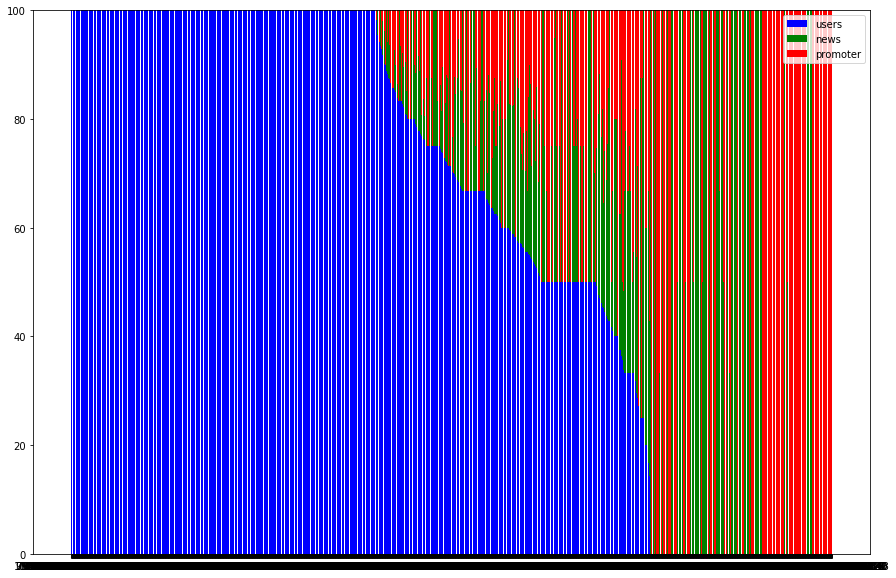

In [37]:
plt.figure(figsize=(15,10))
p1 = plt.bar(users, uexp, color='b',label= "users")
p2 = plt.bar(users, news, bottom=np.array(uexp), color='g',label="news")
p3 = plt.bar(users, prom, 
             bottom=np.array(uexp)+np.array(news), color='r', label= "promoter")
# p4 = plt.bar(ind, dataset[4], width,
#              bottom=np.array(dataset[1])+np.array(dataset[2])+np.array(dataset[3]),
#              color='c')
plt.legend()
plt.show()

In [798]:
## saving the all different no of tweets as a dataframe for viz and future purposes -- dumped
def get_tweet_distr(df,column) -> dict():
    i = 0
    news_t = dict()
    news = np.sort(list(df[column]))
    news_t[0] = 0
    for idx,value in enumerate(news):
        if (value > 30):
            if (value < (i+50) ):
                news_t[i] += 1
            else:
                i = i + 50
                news_t[i] = 1
        if(i > 350):
            break
    return(news_t)

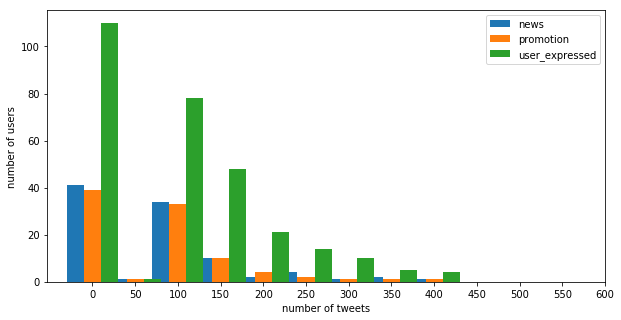

In [799]:
## ploting the news tweets distribution
plt.figure(figsize=(10,5))
news_t = get_tweet_distr(tweets_type,"news")
prom_t = get_tweet_distr(tweets_type, "prom")
euser_t = get_tweet_distr(tweets_type, "user_express") 
# ax = plt.subplot(111)
plt.bar(np.arange(0,len(news_t.keys())*50,50) - 20, news_t.values(), width = 20, label = "news",align='center')
plt.bar(np.arange(0,len(news_t.keys())*50,50), prom_t.values() , width = 20, label= "promotion", align='center')
plt.bar(np.arange(0,len(news_t.keys())*50,50) + 20, euser_t.values(), width = 20, label = "user_expressed", align='center')
plt.xticks(np.arange(0,650,50))
plt.ylabel("number of users")
plt.xlabel("number of tweets")
plt.legend()
plt.show()

In [800]:
## @params dataframe and returns max category of user
def get_category(df) -> int:
    return max(df["news"],df["prom"],df["user_express"])

In [801]:
## predicting users based on the category of
category = list()
for idx,tweet in tweets_type.iterrows():
    cat = np.argmax(list([tweet["news"],tweet["prom"],tweet["user_express"]]))
    category.append(cat)

In [802]:
len(category)

4857

In [803]:
print("promoters",len([ele for ele in category if ele == 0]))
print("news users", len([ele for ele in category if ele == 1]))
print("normal users", len([ele for ele in category if ele == 2]))
normal_users = [ele for ele in category if ele == 2]

promoters 1032
news users 648
normal users 3177


In [804]:
tweets_type["category"] = category

In [805]:
len(tweets_type["userID"].loc[tweets_type.category == 2])

3177

In [806]:
## getting all the tweets from normal users(who have max number of user expressed tweets)
normal_users = list(tweets_type["userID"].loc[tweets_type.category == 2])
normal_tweets = (df_original.loc[df_original.userID.isin(normal_users)])

In [807]:
len(normal_users)

3177

In [716]:
len(normal_tweets.userID.unique())

2157

In [717]:
len(normal_tweets)

42728

## getting poly out of mono

In [718]:
weed_tweets = normal_tweets[normal_tweets['tweetText'].str.contains(pattern_weed, case=False)]
print("weed tweets = ",len(weed_tweets))
poly_users = list(weed_tweets.userID.unique())
print("no of poly users = ", len(poly_users))

weed tweets =  4904
no of poly users =  565


In [719]:
total_users = list(normal_tweets.userID.unique())
poly_length = len(poly_users)
total_users_length = len(total_users)
mono_length = total_users_length - poly_length
print("total users = ", total_users_length)
print("no of poly users = ", poly_length)
print("no of mono users = ", mono_length)
print("% of poly users is ", poly_length / total_users_length)
print("% of mono users is ", mono_length / total_users_length)

total users =  2157
no of poly users =  565
no of mono users =  1592
% of poly users is  0.2619378766805749
% of mono users is  0.7380621233194251


### extracting further poly_before, poly_middle, poly_after

In [720]:
## @return the posotion of juul timeline in the list of weeds
def get_postion(times_j, list_w):
    if list_w is not None:
        pos = -1
        for idx,ele in enumerate(list_w):
            if (times_j) > ele:
                continue
            else:
                pos = idx
                break
        if pos == -1:
            pos = len(list_w)
        return pos

In [721]:
df_user = pd.DataFrame(df_hexagon_data.userID.unique(),columns=["userID"],index=None)
df_user["first_juul"] = first_occurance

In [722]:
## dumping the users with first occurances of juul

In [723]:
print("*** starting with the poly sub type users")
poly_before = list()
poly_after = list()
poly_middle = list()
poly_und = list()
total_users = list(df_input_pred.userID.unique())
for user in tqdm(poly_users):
    user_tweets = df_input_pred.loc[df_input_pred.userID == user]
    user_tweets = user_tweets.sort_values(by='tweetCreatedAt', ascending=True)  # sort by tweet created at
    times_j = None
    list_w = None
    list_j = list(df_user["first_juul"].loc[df_user.userID == user]) ## get the first occurance
    if list_j:
        time_j = pd.to_datetime(list_j[0])
    else:
        time_j = None
    weed_tweets = user_tweets[user_tweets['tweetText'].str.contains(pattern_weed, case=False)]
    if (len(weed_tweets) > 0):
        if (len(weed_tweets) > 0):
            list_w = pd.to_datetime(list(weed_tweets[
                                              'tweetCreatedAt']))
    else:
        list_w = None
    if (time_j is not None and list_w is not None):
        pos = get_postion(time_j,list_w)              ## @TODO change..create function
        if (pos >= len(list_w)):
            poly_after.append(user)
        elif (pos == 0):
            poly_before.append(user)
        else:
            poly_middle.append(user)
    else:
        poly_und.append(user)                         ## if we can't determine the juul tweets in the user..
print("Poly type users calculated")
print("total users =", len(total_users))
print("****************\n")
print("% of poly before users = ", len(poly_before) / len(poly_users))
print("\n")
print("% of poly after users = ", len(poly_after) / len(poly_users))
print("\n")
print("% of poly middle users = ", len(poly_middle) / len(poly_users))
print("\n")
print("% of undefined users = ", len(poly_und) / len(poly_users))

*** starting with the poly sub type users
Poly type users calculated
total users = 4857
****************

% of poly before users =  0.23185840707964603


% of poly after users =  0.31150442477876106


% of poly middle users =  0.45663716814159294


% of undefined users =  0.0


In [637]:
print("len poly user",len(poly_users))
print("length of poly after", len(poly_before))
print("length of poly_middle", len(poly_middle))
print("legth of poly undefines ", len(poly_und))

len poly user 979
length of poly after 238
length of poly_middle 407
legth of poly undefines  1


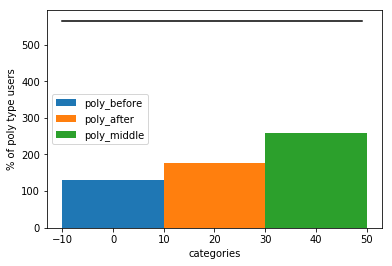

In [759]:
plt.bar(0,len(poly_before),width = 20, label = "poly_before")
plt.bar(20,len(poly_after), width = 20, label = "poly_after")
plt.bar( 40,len(poly_middle), width = 20, label = "poly_middle")
plt.plot(np.arange(-10,50),[len(poly_users) for i in range(60)],color="black")
# plt.bar(["poly_users"],len(poly_users))
plt.xlabel("categories")
plt.ylabel("% of poly type users")
plt.legend()
plt.show()

In [638]:
list(df_hexagon_data.tweetText[df_hexagon_data.userID.isin(poly_und)])

['Teens need to know the facts about vaping and their health #ecigs #ecigarettes #teenhealth  https://t.co/P5FkjLPFbf https://t.co/IwRbza9MBP']

### stats related mono and poly network..

### Loading the graph

In [141]:
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import random
from tqdm import tqdm_notebook as tqdm
import os
import git
import pandas as pd
import ast
import matplotlib
import networkx as nx
import numpy as np
matplotlib.use('Agg')

/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/akshayup

In [4]:
def get_git_root(path):
    git_repo = git.Repo(path, search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root

In [169]:
poly_users_path = os.path.join(get_git_root(os.getcwd()),"models","poly_users")
input_dir = os.path.join(get_git_root(os.getcwd()),"input")

In [84]:
poly_users = pickle.load(open(os.path.join(poly_users_path,"poly_users.pkl"),"rb"))
total_users = pickle.load(open(os.path.join(poly_users_path,"total_users.pkl"),"rb"))
df_following_final = pd.read_csv(os.path.join(input_dir,"following_final.csv"))

In [77]:
path = os.path.join(poly_users_path,"following_net_new.gpickle")
G_poly_net = nx.read_gpickle(path)

### some stats

In [196]:
len(G.nodes)

1773

In [124]:
len(G.edges())

20204

In [169]:
x = (list(G.degree()))
x.sort(key= lambda x:x[1],reverse=False)

In [218]:
def get_deg_node(x):
    graphs_deg = dict()
    i = 0
    graphs_deg[0] = 0
    for node,degree in x:
        if ( degree <= (i+50)):
            graphs_deg[i] += 1
        else:
            i = i + 50
            graphs_deg[i] = 1
    return graphs_deg

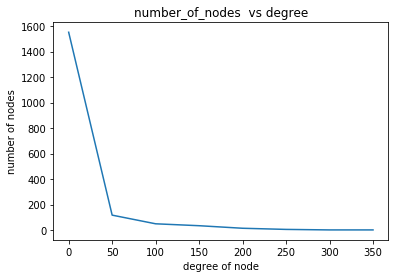

In [187]:
plt.title("number_of_nodes  vs degree")
plt.ylabel("number of nodes")
plt.xlabel("degree of node")
# plt.xticks(np.arange(0,400,100))
plt.plot(graphs_deg.keys(),graphs_deg.values())
plt.show()

In [207]:
def get_avg_deg(x):
    degrees = [degree for node,degree in x]
    avg_degree = sum(degrees) / len(x)
    return avg_degree

In [226]:
def get_poly_mono_deg(G):
    poly_deg = list()
    mono_deg = list()
    for node in G.nodes():
        if node in set(poly_users):
            poly_deg.append((node,G.degree(node)))
        else:
            mono_deg.append((node,G.degree(node)))
    return (poly_deg,mono_deg)

In [211]:
len(poly_deg)

298

In [212]:
print(get_avg_deg(mono_deg))

20.002033898305086


In [213]:
print(get_avg_deg(poly_deg))

36.59395973154363


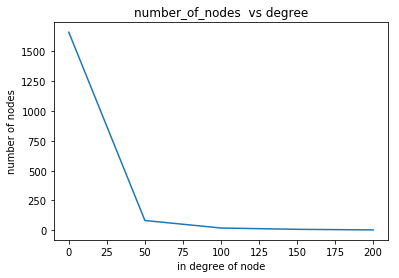

In [223]:
in_degree = list(G.in_degree())
in_degree.sort(key= lambda x:x[1],reverse=False)
indegree = get_deg_node(in_degree)
plt.title("number_of_nodes  vs degree")
plt.ylabel("number of nodes")
plt.xlabel("in degree of node")
# plt.xticks(np.arange(0,400,100))
plt.plot(indegree.keys(),indegree.values())
plt.show()

In [231]:
print("avg in degree " ,get_avg_deg(in_degree))
print("avg in degree poly " ,get_avg_deg(poly_deg))
print("avg in degree mono " ,get_avg_deg(mono_deg))

avg in degree  11.395375070501974
avg in degree poly  18.751677852348994
avg in degree mono  9.909152542372881


In [240]:
out.sort(key= lambda x:x[1],reverse=False)
print("avg out degree " ,get_avg_deg(out))
print("avg out degree poly " ,get_avg_deg(poly_deg))
print("avg out degree mono " ,get_avg_deg(mono_deg))

avg out degree  11.395375070501974
avg out degree poly  17.84228187919463
avg out degree mono  10.092881355932203


## Dumping ground


In [543]:
len(df_hexagon_data.userID.unique())

7371

In [566]:
##get the first occurance of juul for each of the user
users = df_hexagon_data.userID.unique()
first_occurance = list()
for user in tqdm(users):
    user_tweets = df_hexagon_data.loc[df_hexagon_data.userID == user]
    user_t = user_tweets.sort_values(by= "tweetCreatedAt", ascending=True) ## sort the tweets
    ## find all tweets realted to juul
    juul_tweets = user_t.loc[user_tweets["tweetText"].str.contains(pattern_juul, case= False)]
    first = (juul_tweets.head(1)["tweetCreatedAt"])
    if not first.empty:
        first_occurance.append(first.values[0])
    else:
        first_occurance.append(None)

In [594]:
## dumping the first occurances of juul
df_user.to_csv(os.path.join(input_dir,"user_first_juul.csv"))

In [482]:
## saving the all different no of tweets as a dataframe for viz and future purposes
tweets_type.to_csv(os.path.join(poly_users_path,"tweets_type.csv"))

In [114]:
## setting the attribute of node type in the graph
attr = dict()
for node in G.nodes():
    if node in set(poly_users):
        G.nodes[node]['type'] = "poly" 
    else:
        G.nodes[node]['type'] = "mono"

In [121]:
nx.write_gpickle(G,os.path.join(poly_users_path,"following_net_new.gpickle"))

In [232]:
out = (list(G.out_degree()))
poly_deg = list()
mono_deg = list()
for node in G.nodes():
    if node in set(poly_users):
        poly_deg.append((node,G.out_degree(node)))
    else:
        mono_deg.append((node,G.out_degree(node)))

In [483]:
## dump the labelled data
filepath = os.path.join(input_dir,"labelled_data")
df_original.to_csv(os.path.join(filepath,"tweets_predicted.csv"))

In [809]:
# dump the poly_users
poly_dir = os.path.join(model_dir,"poly_users")

In [810]:
poly_dir

'/home/samarthgoal/twitter_juul/models/poly_users'

In [761]:
poly_users_file = os.path.join(poly_dir,"poly_users.pkl")
with open(poly_users_file,"wb") as f:
    pickle.dump(poly_users,f)

In [762]:
poly_users_file = os.path.join(poly_dir,"poly_before.pkl")
with open(poly_users_file,"wb") as f:
    pickle.dump(poly_before,f)
poly_users_file = os.path.join(poly_dir,"poly_after.pkl")
with open(poly_users_file,"wb") as f:
    pickle.dump(poly_before,f)
poly_users_file = os.path.join(poly_dir,"poly_middle.pkl")
with open(poly_users_file,"wb") as f:
    pickle.dump(poly_middle,f)

In [766]:
poly_dir

'/home/samarthgoal/twitter_juul/models/poly_wrt'

In [808]:
len(normal_users)

3177

In [811]:
poly_users_file = os.path.join(poly_dir,"normal_users.pkl")
with open(poly_users_file,"wb") as f:
    pickle.dump(normal_users,f)